<a href="https://colab.research.google.com/github/JSJeong-me/Introduction-to-Data-Analysis-with-DL-and-ML/blob/main/2-ML/61-xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### XGBoosting

https://nbviewer.jupyter.org/github/jphall663/interpretable_machine_learning_with_python/blob/master/xgboost_pdp_ice.ipynb?flush_cache=trueXGBoosting


In [1]:
import numpy as np                   # array, vector, matrix calculations
import pandas as pd                  # DataFrame handling
#import shapely as shap                          # for consistent, signed variable importance measurements
import xgboost as xgb                # gradient boosting machines (GBMs)

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of plots in notebook
%matplotlib inline

np.random.seed(42)               # set random seed for reproducibility

#### Import data and clean

In [2]:
# import XLS file
path = "./credit_cards_dataset.csv"

data = pd.read_csv(path) # skip the first row of the spreadsheet

In [3]:
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [4]:
# remove spaces from target column name
data = data.rename(columns={'default.payment.next.month': 'DEFAULT_NEXT_MONTH'})

In [5]:
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'DEFAULT_NEXT_MONTH'],
      dtype='object')

In [ ]:
#profile.to_file(outputfile="my.html")

In [ ]:
data.head(10)

In [ ]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
# y='default.payment.next.month'
X = [name for name in data.columns if name not in [y, 'ID', 'Y_Value']]
print('y =', y)
print('X =', X)

In [ ]:
data[X].describe()

In [ ]:
data[X]

In [ ]:
data[X + [y]].describe() # display descriptive statistics for all columns

In [ ]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(data[X + [y]].corr(method='spearman')[y]).iloc[:-1]

In [16]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])

# (-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)

In [17]:
np.random.seed(42) # set random seed for reproducibility
split_ratio = 0.7     # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21087, columns = 25
Test data rows = 8913, columns = 25


In [18]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

In [19]:
# used to calibrate predictions to mean of y
base_y = train[y].mean()

# tuning parameters
params = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'auc',                       # stop training based on maximum AUC, AUC always between 0-1
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'monotone_constraints':mono_constraints,    # 1 = increasing relationship, -1 = decreasing relationship
    'base_score': base_y,                       # calibrate predictions to mean of y
    'seed': 42                               # set random seed for reproducibility
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

In [ ]:
# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above
                      dtrain,                   # training data
                      1000,                     # maximum of 1000 iterations (trees)
                      evals=watchlist,          # use watchlist for early stopping
                      early_stopping_rounds=50, # stop after 50 iterations (trees) without increase in AUC
                      verbose_eval=True)        # display iteration progress

In [22]:
# dtest is DMatrix
# shap_values is Numpy array
shap_values = xgb_model.predict(dtest, pred_contribs=True) #, ntree_limit=xgb_model.best_ntree_limit

In [24]:
ypred=xgb_model.predict(dtest) #  ntree_limit=xgb_model.best_ntree_limit

In [26]:
ypred[:10]

array([0.3041    , 0.1185302 , 0.14462541, 0.19160384, 0.08326435,
       0.05881941, 0.13851725, 0.00990946, 0.04653033, 0.18977793],
      dtype=float32)

In [27]:
ypred.reshape(-1,1)
predictions = np.array([round(value) for value in ypred])

In [28]:
predictions.reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

accuracy = accuracy_score(test[y], predictions)
cm = confusion_matrix(test[y], predictions)
precision = precision_score(test[y], predictions)
recall = recall_score(test[y], predictions)

In [30]:
print(accuracy)
print(cm)
print(precision)
print(recall)

0.817345450465612
[[6549  356]
 [1272  736]]
0.673992673992674
0.3665338645418327


In [31]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

Confusion matrix, without normalization
[[6549  356]
 [1272  736]]


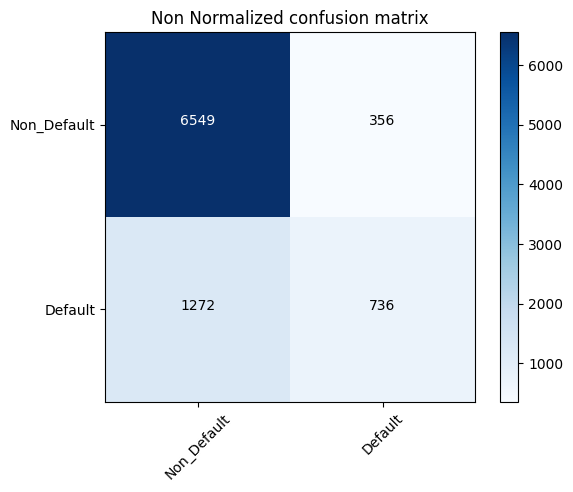

In [32]:
plt.figure()
plot_confusion_matrix(cm, classes=['Non_Default','Default'], normalize=False,
                      title='Non Normalized confusion matrix')

In [ ]:
# plot Shapley variable importance summary
#import shap
#shap.summary_plot(shap_values[:, :-1], test[xgb_model.feature_names])
#shap.TreeExplainer(shap_values[:, :-1], test[xgb_model.feature_names])

In [ ]:
#https://www.kaggle.com/dansbecker/shap-values

### PDP

In [ ]:
def par_dep(xs, frame, model, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence for a
        single variable.

    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced
              points between column minimum and maximum.

    Returns:
        Pandas DataFrame containing partial dependence values.

    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])

    # cache original column values
    col_cache = frame.loc[:, xs].copy(deep=True)

    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe, ntree_limit=model.best_ntree_limit))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j},
                                              ignore_index=True)

    # return input frame to original cached state
    frame.loc[:, xs] = col_cache

    return par_dep_frame

In [ ]:
par_dep_PAY_0 = par_dep('PAY_0', test[X], xgb_model)         # calculate partial dependence for PAY_0
par_dep_LIMIT_BAL = par_dep('LIMIT_BAL', test[X], xgb_model) # calculate partial dependence for LIMIT_BAL
par_dep_BILL_AMT1 = par_dep('BILL_AMT1', test[X], xgb_model) # calculate partial dependence for BILL_AMT1

# display partial dependence for LIMIT_BAL
par_dep_LIMIT_BAL

In [ ]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on
        another column id_.

    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_.

    Returns:
        Dictionary of percentile values and index column values.

    """

    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

In [ ]:
# merge GBM predictions onto test data
yhat_test = pd.concat([test.reset_index(drop=True), pd.DataFrame(xgb_model.predict(dtest))], axis=1)
yhat_test = yhat_test.rename(columns={0:'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
percentile_dict = get_percentile_dict('p_DEFAULT_NEXT_MONTH', 'ID', yhat_test)

# display percentiles dictionary
# ID values for rows
# from lowest prediction
# to highest prediction
percentile_dict

### ICE

In [ ]:
# retreive bins from original partial dependence calculation

bins_PAY_0 = list(par_dep_PAY_0['PAY_0'])
bins_LIMIT_BAL = list(par_dep_LIMIT_BAL['LIMIT_BAL'])
bins_BILL_AMT1 = list(par_dep_BILL_AMT1['BILL_AMT1'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(percentile_dict.keys()):

    col_name = 'Percentile_' + str(i)

    # ICE curves for PAY_0 across percentiles at bins_PAY_0 intervals
    par_dep_PAY_0[col_name] = par_dep('PAY_0',
                                    test[test['ID'] == int(percentile_dict[i])][X],
                                    xgb_model,
                                    bins=bins_PAY_0)['partial_dependence']

    # ICE curves for LIMIT_BAL across percentiles at bins_LIMIT_BAL intervals
    par_dep_LIMIT_BAL[col_name] = par_dep('LIMIT_BAL',
                                          test[test['ID'] == int(percentile_dict[i])][X],
                                          xgb_model,
                                          bins=bins_LIMIT_BAL)['partial_dependence']



    # ICE curves for BILL_AMT1 across percentiles at bins_BILL_AMT1 intervals
    par_dep_BILL_AMT1[col_name] = par_dep('BILL_AMT1',
                                          test[test['ID'] == int(percentile_dict[i])][X],
                                          xgb_model,
                                          bins=bins_BILL_AMT1)['partial_dependence']

In [ ]:
par_dep_LIMIT_BAL

### Plotting partial dependence and ICE to validate and explain monotonic behavior

In [ ]:
#### Function to plot partial dependence and ICE

def plot_par_dep_ICE(xs, par_dep_frame):


    """ Plots ICE overlayed onto partial dependence for a single variable.

    Args:
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.

    """

    # initialize figure and axis
    fig, ax = plt.subplots()

    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs,
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs,
                       y='partial_dependence',
                       style='r-',
                       linewidth=3,
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3,
                   borderaxespad=0.)

In [ ]:
plot_par_dep_ICE('LIMIT_BAL', par_dep_LIMIT_BAL) # plot partial dependence and ICE for LIMIT_BAL

In [ ]:
_ = train['LIMIT_BAL'].plot(kind='hist', bins=20, title='Histogram: LIMIT_BAL')

In [ ]:
plot_par_dep_ICE('PAY_0', par_dep_PAY_0) # plot partial dependence and ICE for PAY_0

In [ ]:
_ = train['PAY_0'].plot(kind='hist', bins=20, title='Histogram: PAY_0')

In [ ]:
plot_par_dep_ICE('BILL_AMT1', par_dep_BILL_AMT1) # plot partial dependence and ICE for BILL_AMT1

In [ ]:
_ = train['BILL_AMT1'].plot(kind='hist', bins=20, title='Histogram: BILL_AMT1')

### Generate reason codes using the Shapley method

In [ ]:
test.reset_index(drop=True, inplace=True)

In [ ]:
decile = 99
row = test[test['ID'] == percentile_dict[decile]]

In [ ]:
# reset test data index to find riskiest customer in shap_values
# sort to find largest positive contributions
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(23, 1), columns=['Reason Codes'], index=X)
s_df.sort_values(by='Reason Codes', inplace=True, ascending=False)

In [ ]:
s_df

In [ ]:
_ = s_df[:5].plot(kind='bar',
                  title='Top Five Reason Codes for a Risky Customer\n',
                  legend=False)

In [ ]:
row # helps understand reason codes